In [37]:
import pandas as pd
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
import cv2
from pycocotools.coco import COCO
import os
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_df = pd.read_csv('data/dataset_firstTest/train_100dogs_100cats_100nocatsnodogs/train_for_OutSegmentationModelTest.csv')
train_df = train_df[train_df['label']=='dog']
train_df.head()

,image_id,image_path,mask_image_path,label,num_elements_of_label_category
100,185250,000000185250.jpg,000000185250_mask.pkl,dog,1
101,329219,000000329219.jpg,000000329219_mask.pkl,dog,1
102,29393,000000029393.jpg,000000029393_mask.pkl,dog,1
103,107226,000000107226.jpg,000000107226_mask.pkl,dog,3
104,134112,000000134112.jpg,000000134112_mask.pkl,dog,1


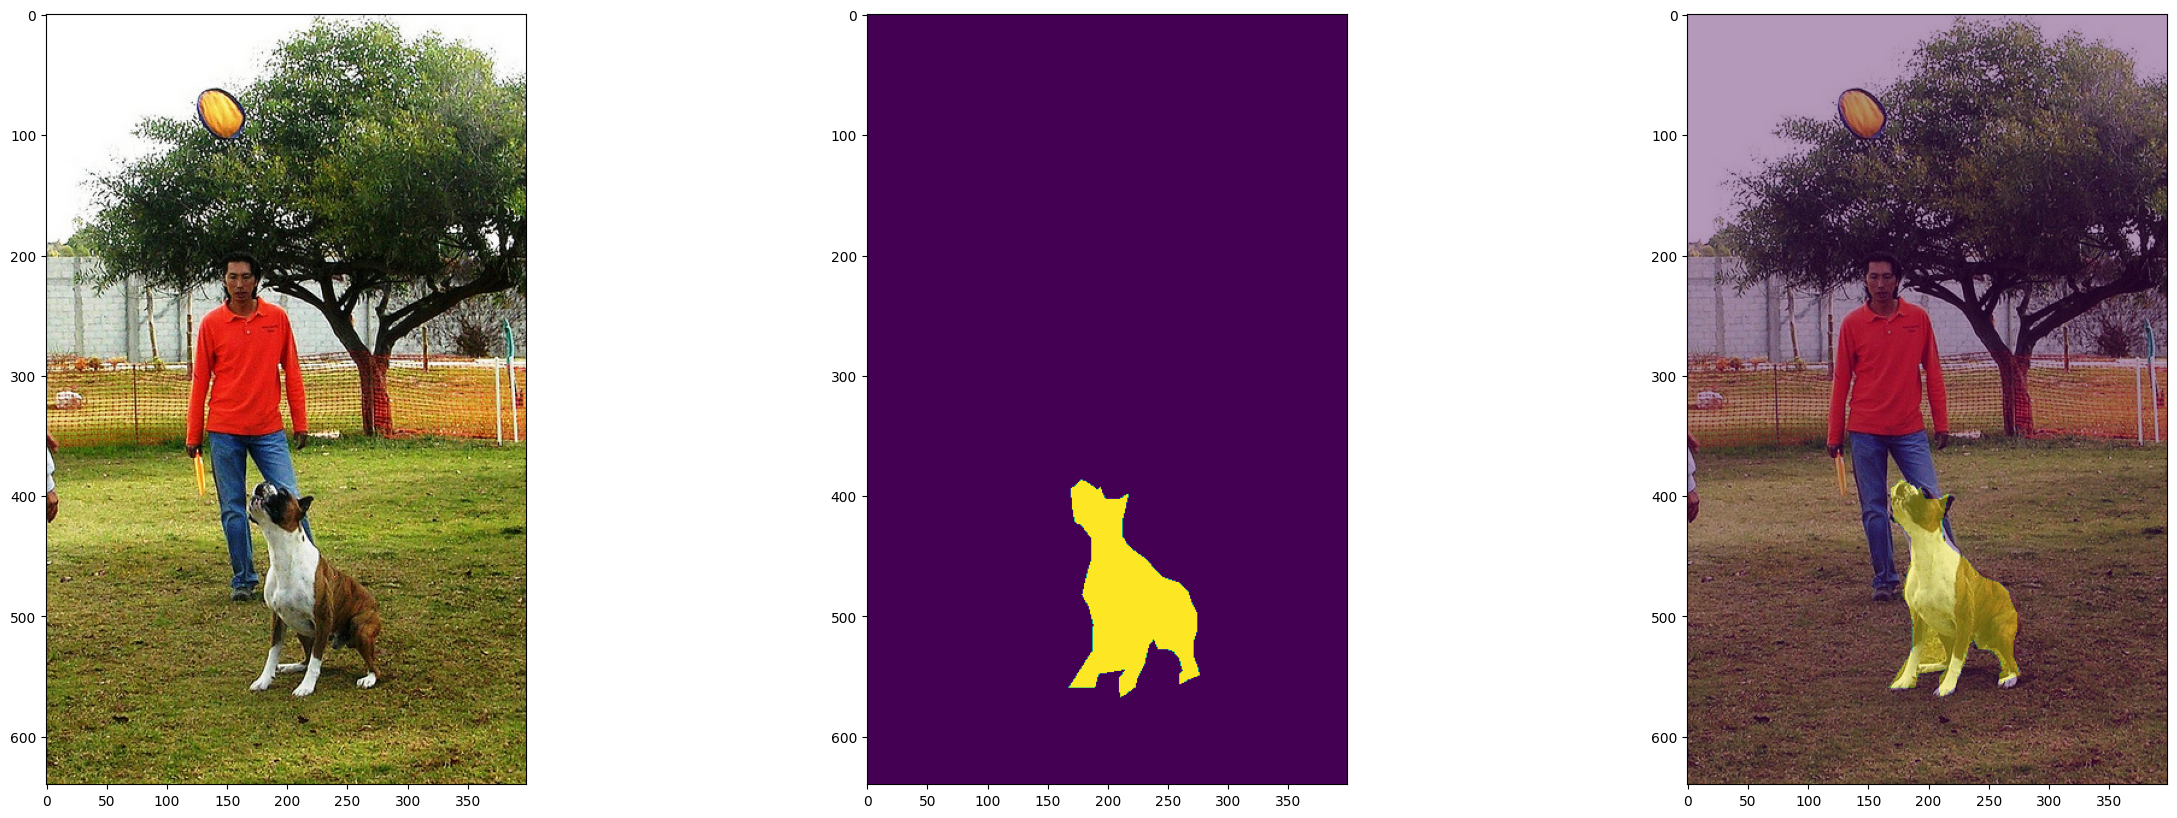

In [3]:
img = Image.open('data/dataset_firstTest/train_100dogs_100cats_100nocatsnodogs/images/'+train_df['image_path'].iloc[0])
img = (np.array(img)/255).astype('float32')
with open('data/dataset_firstTest/train_100dogs_100cats_100nocatsnodogs/masks/'+train_df['mask_image_path'].iloc[0], 'rb') as f:
    img_mask = pickle.load(f).astype('int8')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(img)
ax2.imshow(img_mask)
ax3.imshow(img)
ax3.imshow(img_mask, alpha=0.4)
plt.show()

In [4]:
img.shape, img.dtype, img.max(), img.min()

((640, 399, 3), dtype('float32'), 1.0, 0.0)

In [5]:
img_mask.shape, img_mask.dtype, img_mask.max(), img_mask.min()

((640, 399), dtype('int8'), 1, 0)

In [6]:
mask_oh = (np.arange(2) == img_mask[...,None]).astype(np.float32) 

mask_oh.shape, mask_oh.dtype, mask_oh.max(), mask_oh.min()

((640, 399, 2), dtype('float32'), 1.0, 0.0)

In [45]:
import torch.nn.functional as F

def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

def encoder_conv(ci, co):
  return torch.nn.Sequential(
        torch.nn.MaxPool2d(2),
        conv3x3_bn(ci, co),
        conv3x3_bn(co, co),
    )

class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)
    
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))

        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class UNet(torch.nn.Module):
    def __init__(self, n_classes=2, in_ch=3):
        super().__init__()

        c = [16, 32, 64, 128]

        self.conv1 = torch.nn.Sequential(
          conv3x3_bn(in_ch, c[0]),
          conv3x3_bn(c[0], c[0]),
        )

        self.conv2 = encoder_conv(c[0], c[1])
        self.conv3 = encoder_conv(c[1], c[2])
        self.conv4 = encoder_conv(c[2], c[3])

        self.deconv1 = deconv(c[3],c[2])
        self.deconv2 = deconv(c[2],c[1])
        self.deconv3 = deconv(c[1],c[0])

        self.out = torch.nn.Conv2d(c[0], n_classes, 3, padding=1)

    def forward(self, x):
        # encoder
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x = self.conv4(x3)

        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x)
        return x

In [47]:
model = UNet()
output = model(torch.randn((1,3,512,512)))
output.shape

torch.Size([1, 2, 512, 512])

# Training just one example

In [52]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def iou(outputs, labels):
    # aplicar sigmoid y convertir a binario
    outputs, labels = torch.sigmoid(outputs) > 0.5, labels > 0.5
    SMOOTH = 1e-6
    # BATCH x num_classes x H x W
    B, N, H, W = outputs.shape
    ious = []
    for i in range(N-1): # saltamos el background
        _out, _labs = outputs[:,i,:,:], labels[:,i,:,:]
        intersection = (_out & _labs).float().sum((1, 2))  
        union = (_out | _labs).float().sum((1, 2))         
        iou = (intersection + SMOOTH) / (union + SMOOTH)  
        ious.append(iou.mean().item())
    return np.mean(ious) 

def fit(model, X, y, epochs=1, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    X, y = X.to(device), y.to(device)
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, y)
        print(f"Epoch {epoch}/{epochs} loss {loss.item():.5f} iou {ious:.5f}")

In [50]:
resized_img = cv2.resize(img, (512, 512), interpolation=cv2.INTER_NEAREST)
resized_mask_oh = cv2.resize(mask_oh, (512, 512), interpolation=cv2.INTER_NEAREST)
resized_img_tensor = torch.tensor(resized_img).permute(2,0,1).unsqueeze(0)
resized_mask_oh_tensor = torch.tensor(resized_mask_oh).permute(2, 0, 1).unsqueeze(0)
resized_img_tensor.shape, resized_mask_oh_tensor.shape

(torch.Size([1, 3, 512, 512]), torch.Size([1, 2, 512, 512]))

In [69]:
fit(model, resized_img_tensor, resized_mask_oh_tensor, epochs=70)

Epoch 1/50 loss 0.18182 iou 0.99574
Epoch 2/50 loss 0.22242 iou 0.96153
Epoch 3/50 loss 0.17365 iou 0.98458
Epoch 4/50 loss 0.17454 iou 0.97977
Epoch 5/50 loss 0.15362 iou 0.98964
Epoch 6/50 loss 0.15046 iou 0.98284
Epoch 7/50 loss 0.14271 iou 0.98361
Epoch 8/50 loss 0.13129 iou 0.98752
Epoch 9/50 loss 0.12164 iou 0.99208
Epoch 10/50 loss 0.11304 iou 0.99338
Epoch 11/50 loss 0.10435 iou 0.99441
Epoch 12/50 loss 0.09953 iou 0.99332
Epoch 13/50 loss 0.09446 iou 0.99304
Epoch 14/50 loss 0.08800 iou 0.99432
Epoch 15/50 loss 0.08296 iou 0.99501
Epoch 16/50 loss 0.07713 iou 0.99568
Epoch 17/50 loss 0.07224 iou 0.99610
Epoch 18/50 loss 0.06865 iou 0.99599
Epoch 19/50 loss 0.06524 iou 0.99598
Epoch 20/50 loss 0.06154 iou 0.99610
Epoch 21/50 loss 0.05813 iou 0.99626
Epoch 22/50 loss 0.05492 iou 0.99651
Epoch 23/50 loss 0.05189 iou 0.99676
Epoch 24/50 loss 0.04942 iou 0.99677
Epoch 25/50 loss 0.04689 iou 0.99687
Epoch 26/50 loss 0.04445 iou 0.99711
Epoch 27/50 loss 0.04238 iou 0.99712
Epoch 28/5

In [61]:
np.unique(resized_mask_oh.sum(2))

array([1.], dtype=float32)

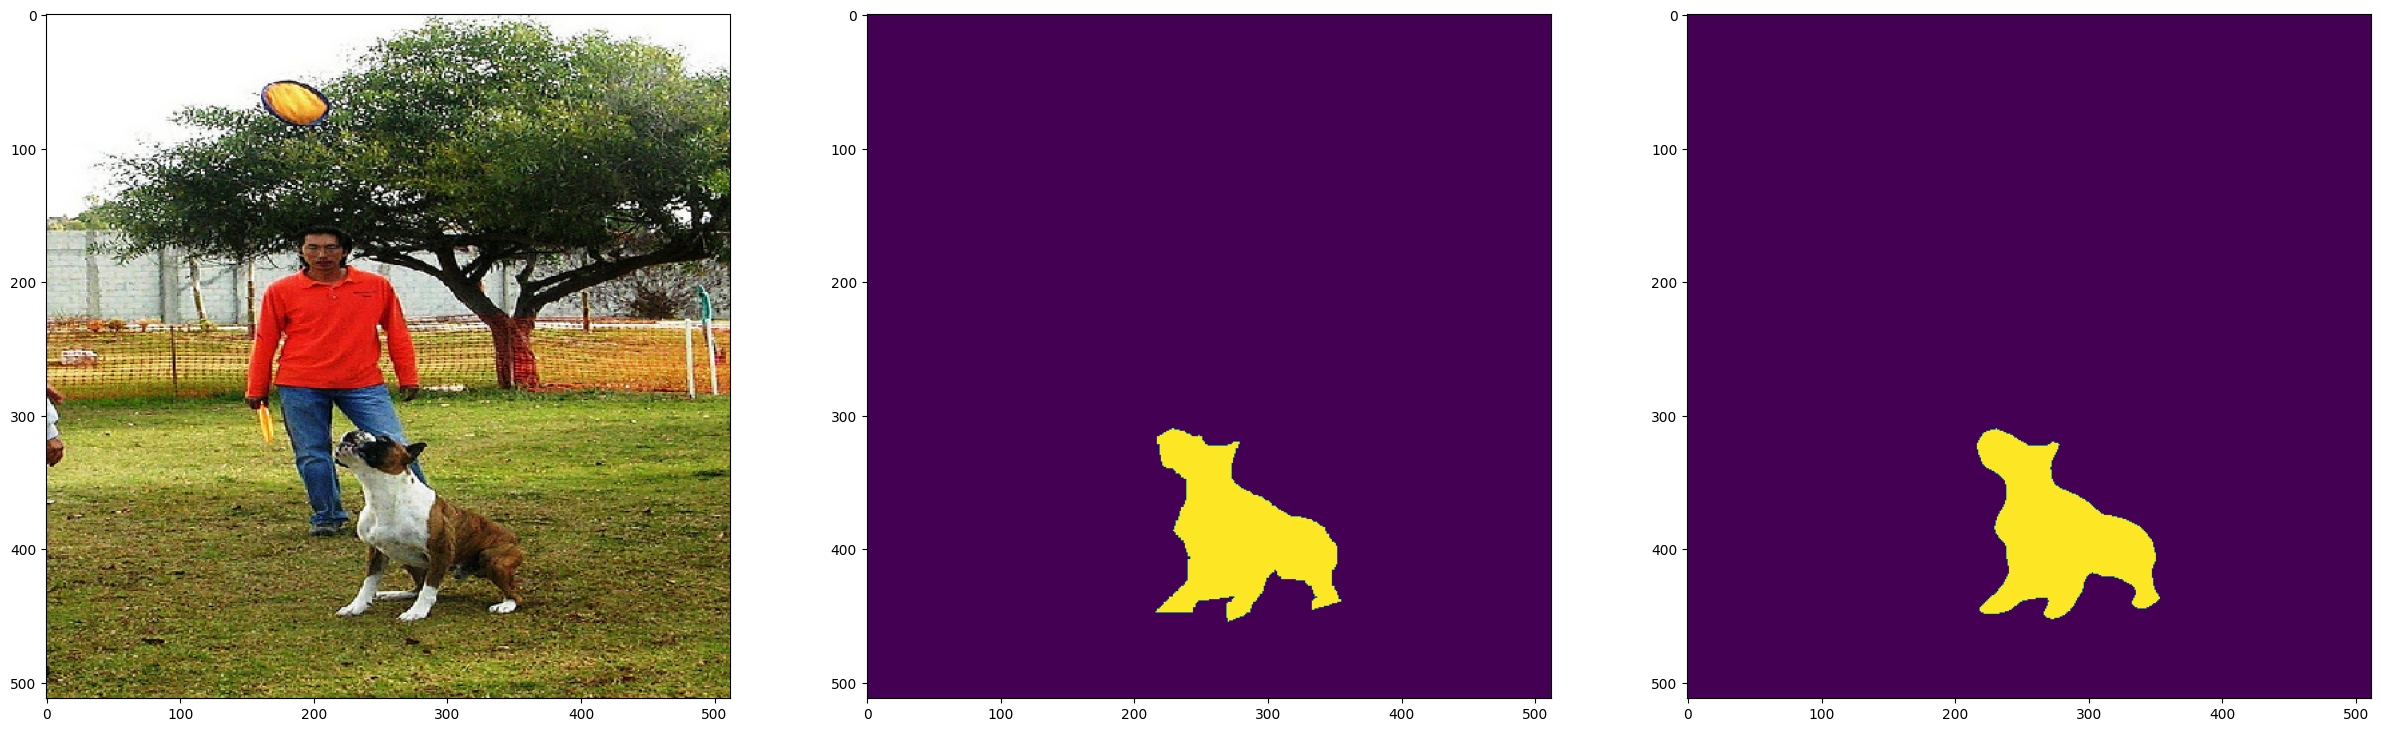

In [70]:
model.eval()
with torch.no_grad():
    output = model(resized_img_tensor.to(device))[0]
    pred_mask = torch.argmax(output, axis=0)
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(resized_img)
ax2.imshow(cv2.resize(img_mask, (512, 512), interpolation=cv2.INTER_NEAREST))
ax3.imshow(pred_mask.squeeze().cpu().numpy())
plt.show()

In [68]:
output.shape

torch.Size([2, 512, 512])